<a href="https://colab.research.google.com/github/rajagopalmotivate1/NeuralDefense/blob/master/attack_cnn_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attacking a CNN

In this exercise we will train a CNN to distinguish between instances of handwritten `0` and instances of handwritten `1`. We will be using `keras` to do this.  

Once we have a trained classifier, we will be using `cleverhans` to create adversarial examples.

In [0]:
!pip install pydot


In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [0]:
import tensorflow as tf
from keras import Input
from keras import layers
from keras import datasets
import numpy as np
from keras import utils
from keras.models import  Model
from keras.utils import plot_model
import keras
import os
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from decimal import Decimal
import  matplotlib.pyplot as plt
from scipy.misc import toimage
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.utils import plot_model
from google.colab import files

In [0]:
!pip install cleverhans

In [0]:
import warnings
import numpy as np
import os
with warnings.catch_warnings():
    import keras # keras is still using some deprectade code
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import BasicIterativeMethod, FastGradientMethod, CarliniWagnerL2
%matplotlib inline 
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


The MNIST dataset contains data for all of the digits, but for now we are only interested in 1s and 0s. Therefore we are extracting only those from the dataset. 

We also need to normalize the data. This means that whatever interval was previously covered by the input values will be squashed to `[0,1]`

In [0]:
def exract_ones_and_zeroes( data, labels ):
    data_zeroes = data[ np.argwhere( labels == 0 ).reshape( -1 ) ][ :9900 ]
    print( data_zeroes.shape )
    data_ones = data[ np.argwhere( labels == 1 ).reshape( -1 ) ][ :2000 ]
    x = np.vstack( (data_zeroes, data_ones) )

    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

Load the actual data and use our preprocessing function from earlier.

In [0]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:20000]
y_train = y_train[:20000]

# extract ones and zeroes
#x_train, y_train = exract_ones_and_zeroes( x_train, y_train )
#x_test, y_test = exract_ones_and_zeroes( x_test, y_test )


Keras expects the image to have a color channel. We need to add another dimension to our image to represent
that color channel.

In [0]:
# we need to bring the data in to a format that our cnn likes
y_train = keras.utils.to_categorical( y_train, 10 )
y_test = keras.utils.to_categorical( y_test, 10 )

if keras.backend.image_data_format( ) == 'channels_first':
    x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    input_shape = (1, x_train.shape[ 1 ], x_train.shape[ 2 ])
else:
    x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
    x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
    input_shape = (x_train.shape[ 1 ], x_train.shape[ 2 ], 1)



We need to make sure that `cleverhans` has access to our model graph. To do this we make sure that `keras` uses the same `tensorflow` session that `cleverhans` will be using. 

In [0]:
# need to some setup so everything gets excecuted in the same tensorflow session
session = tf.Session( )
keras.backend.set_session( session )

We are using a very simple CNN. For our two output classes this is probably overkill. This network can be used to distinguish between all 10 classes with very high accuracy.

In [0]:
# define the classifier
clf = keras.Sequential( )
clf.add( Conv2D( 32, kernel_size=(3, 3), activation='relu', input_shape=input_shape ) )
clf.add( Conv2D( 64, (3, 3), activation='relu' ) )
clf.add( MaxPooling2D( pool_size=(2, 2) ) )
clf.add( Dropout( 0.25 ) )
clf.add( Flatten( ) )
clf.add( Dense( 128, activation='relu' ) )
clf.add( Dropout( 0.5 ) )
clf.add( Dense( 10, activation='softmax' ) )

In [0]:

#Input parameters are depthofnetwork, generalization capacity , 

def createANetwork(ExpNo, noofCNNlayers, noofDenselayers, noofCNNFilters, noofDensenodes  ,
                  networkwidthTamperRate, stride, maxpool, noofPARALLELbranches , kernalsize):
    myinputShape = (32, 32, 3)
    myinputTensor = Input(shape=myinputShape, name='1')
    x = myinputTensor
    layerno = 1
    isskipaddingMaxPool = True
    
    for i in range(noofCNNlayers):
        x = layers.Conv2D(noofCNNFilters, kernel_size=(kernalsize,kernalsize), strides=(stride,stride), activation='relu', name='CNNlayer'+str(layerno)) (x)
        print( str(layerno) + ' Conv2D  Filters=' + str(noofCNNFilters) + '.    kernel size=(' + str(kernalsize) + ' , ' + str(kernalsize) + ' )'  + ' . stride=' + str(stride) + '     Relu')
        x = layers.BatchNormalization()(x)
        layerno = layerno +1
        if(layerno > 3):
            maxpool = 1
        if(layerno > 1):
            stride = 1
        if (isskipaddingMaxPool == False):
            x = layers.MaxPooling2D(pool_size=(maxpool, maxpool), name='MaxPool'+str(layerno)) (x)
            print( str(layerno) + ' MaxPool  . Poolsize=' + str(maxpool) )
            layerno = layerno +1
            x = layers.Dropout(0.2) (x)
            print( '  Dropout 0.2' )
            isskipaddingMaxPool = True
            noofCNNFilters = round( noofCNNFilters * networkwidthTamperRate )
            if(noofCNNFilters>512):
                noofCNNFilters = 512
        else:
            isskipaddingMaxPool = False


    x = layers.Flatten(name='Flatten' + str(layerno) ) (x)
    print(str(layerno) + ' Flatten  ' )

    layerno = layerno + 1

    for i in range(noofDenselayers):
        x = layers.Dense(noofDensenodes, activation='relu', name='Dense'+ str(layerno) )(x)
        print( str(layerno) + ' Dense  ' + str(noofDensenodes) )
        layerno = layerno +1
        noofDensenodes = round(noofDensenodes/2)

    myoutputTensor = layers.Dense(10, activation='softmax', name='DenseMultiClassSoftmaxLayer') (x)

    mymodel = Model(myinputTensor, myoutputTensor)

    
    plot_model(mymodel, show_shapes=False, show_layer_names=True, to_file='achildmodel.png')
    print(mymodel.summary())


    

  #  plot_model(mymodel, show_shapes=True, to_file='models'+str(ExpNo) + '.png')
   # plot_model(mymodel, show_shapes=False, to_file='m'+str(ExpNo) + '.png')


    return mymodel

In [0]:
def create_callbacks(expno):
   # tensorboard_callback = TensorBoard(log_dir=os.path.join(os.getcwd(), "log", "am18d301_Exp1" + str(expno) ), histogram_freq=1, batch_size=32,   write_graph=False, write_grads=False)
   # checkpoint_callback = ModelCheckpoint(filepath="./model-weights.{epoch:02d}.hdf5", monitor='val_acc', verbose=0, save_best_only=True)
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=1, verbose=1, mode='auto')
    return [ earlystop]



def print_model_metrics(model, xtest, ytest ):
    loss, accuracy = model.evaluate(x=xtest, y=ytest)
    print("\n model test loss is "+str(loss)+" accuracy is "+str(accuracy))

    y_softmax = model.predict(xtest)  # this is an n x class matrix of probabilities
    y_hat = y_softmax.argmax(axis=-1)  # this will be the class number.
    test_y = ytest.argmax(axis=-1)  # our test data is also categorical
    print(classification_report(test_y, y_hat))
    return [loss, accuracy]


def plot_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    plt.show()


def convertprecision(alongfloat):
    alongfloat1 = Decimal(alongfloat * 100)
    alongfloat2 = round(alongfloat1, 2)
    myformatedfloat = float(alongfloat2)
    return myformatedfloat

In [0]:

def runaexpeirment(ExpName, anetworkmodel):

    mymodel = anetworkmodel

    (xtrain1, ytrain1), (xtest, ytest) = datasets.cifar10.load_data()
    
    plot_imgs(xtrain1[:16])

    xtrain  = xtrain1[:42000, :]
    ytrain = ytrain1[:42000, :]

    xval = xtrain1[42000:, :]
    yval = ytrain1[42000:, :]

    datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
    datagen.fit(xtrain)
    

    print( 'Shape of CIFAR Training Set Inputs: ' + str(xtrain.shape) )
    print( 'Shape of CIFAR Training Set Labels: ' + str(ytrain.shape) )
    print( 'Shape of CIFAR Test Set Inputs: ' + str(xtest.shape) )
    print( 'Shape of CIFAR Validation Set Inputs: ' + str(xval.shape) )


    xtrain = xtrain.astype('float16') * 1/255
    xtest = xtest.astype('float16') * 1/255
    xval = xval.astype('float16') * 1/255

    trainSetSize = len(xtrain)
    testSetSize = len(xtest)
    valSetSize = len(xval)

    xtrain = xtrain.reshape((trainSetSize, 32, 32, 3))
    xtest = xtest.reshape((testSetSize, 32, 32, 3))
    xval = xval.reshape((valSetSize,32, 32, 3))

    ytrain = utils.to_categorical(ytrain)
    ytest = utils.to_categorical(ytest)
    yval = utils.to_categorical(yval)

    print('After preprocessing.. normalize to 1, OHE, reshaping')
    print( 'Shape of CIFAR Training Set Inputs: ' + str(xtrain.shape) )
    print( 'Shape of CIFAR Training Set Labels: ' + str(ytrain.shape) )
    print( 'Shape of CIFAR Test Set Inputs: ' + str(xtest.shape) )


    mymodel.compile(optimizer=keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=["accuracy"])

    mycallbacksfunction = create_callbacks(ExpName)

   # history = mymodel.fit(xtrain, ytrain, epochs=2, batch_size=128,
                         # validation_data=(xval,yval),
                         # verbose=1, 
                         # callbacks=mycallbacksfunction
                         # )

    mybatchsize = 128
    history = mymodel.fit_generator( datagen.flow(xtrain, ytrain, batch_size=mybatchsize),
                    steps_per_epoch=xtrain.shape[0] / mybatchsize, 
                    epochs=1,
                    verbose=1,
                    validation_data=(xval,yval)
                      )

    #save to disk
    model_json = mymodel.to_json()
    with open('model' + str(ExpName) + 's.json', 'w') as json_file:
        json_file.write(model_json)
    mymodel.save_weights('model'  + str(ExpName) + 's.h5') 

    myTESTloss, myTESTaccuracy = print_model_metrics( mymodel, xtest, ytest )
    myVALloss, myVALaccuracy = print_model_metrics( mymodel, xval, yval )
    myTRAINloss, myTRAINaccuracy = print_model_metrics( mymodel, xtrain, ytrain)

    myTESTaccuracy = convertprecision(myTESTaccuracy)
    myVALaccuracy = convertprecision(myVALaccuracy)
    myTRAINaccuracy = convertprecision(myTRAINaccuracy)
    

    print(' \n RESULTS')
    print('TRAINING accuracy = ' + str(myTRAINaccuracy ))
    print('VAL accuracy = ' + str(myVALaccuracy))
    print('TEST accuracy = ' + str(myTESTaccuracy))
    
    

    return myTRAINaccuracy, myVALaccuracy, myTESTaccuracy

In [0]:
ExpName = 2000
islistcreated = False
ListofNetworks = list()
nooffiltersstarting =  32
networkwidthTamperRate = 2
noofDenselayers = 0
noofDensenodes = 64 
stride = 1
maxpool = 2
noofPARALLELbranches = 1
noofCNNlayers = 6
kernalsize = 3

In [0]:
for iterate in range( 3, 6, 1):
  
    noofCNNlayers = iterate 
  
    ExpName = ExpName + 1
    generatedNetwork =  createANetwork(ExpName, noofCNNlayers,noofDenselayers, nooffiltersstarting, noofDensenodes  ,networkwidthTamperRate, stride, maxpool,  noofPARALLELbranches, kernalsize )
    aTRAINaccuracy, aVALaccuracy, aTESTaccuracy = runaexpeirment(ExpName, generatedNetwork )

    atuple = tuple((ExpName, aTRAINaccuracy, aVALaccuracy, aTESTaccuracy ,  noofCNNlayers,noofDenselayers,  nooffiltersstarting, noofDensenodes  ,networkwidthTamperRate  , stride, maxpool, noofPARALLELbranches , kernalsize, generatedNetwork))

    ListofNetworks.append(atuple)

    print(" ADDED")
    print(atuple)

In [0]:


clf.compile( loss=keras.losses.categorical_crossentropy,
             optimizer='adam',
             metrics=[ 'accuracy' ] )

clf.fit( x_train, y_train,
         epochs=2,
         verbose=1 )
#clf.summary( )
score = clf.evaluate( x_test, y_test, verbose=0 )
print( 'Test loss:', score[ 0 ] )
print( 'Test accuracy:', score[ 1 ] )


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
20000/20000 [==============================] - 64s 3ms/step - loss: 11.1107 - acc: 0.3068
Epoch 2/2
20000/20000 [==============================] - 63s 3ms/step - loss: 7.5729 - acc: 0.5276
Test loss: 6.539933492279053
Test accuracy: 0.5928


Let's get to the actual attack magic. First we are picking a sample that we want to perturbate. After selecting the sample, we will use the FGSM attack and the Carlini & Wagner L2 attack to perturbate it into an adversarial example.

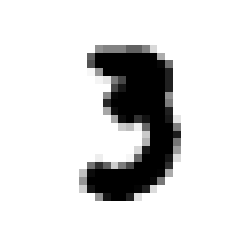

[INFO 2019-03-11 16:26:06,953 cleverhans] Constructing new graph for attack FastGradientMethod


class prediction for the test samples: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
dim is deprecated, use axis instead
class prediction for the modified test samples: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


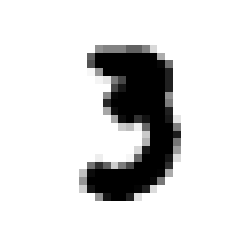

In [0]:
#chose a sample to pertubate
sample_ind = 93

# picking a test sample
sample = x_test[ sample_ind, : ]


# plot the first instance in the traning set
plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

# constructing adversarial examples
print( 'class prediction for the test samples:',
       clf.predict( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )

prediction1 = clf.predict( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )

print ( np.round(prediction1 , 2 ) )

print ( np.round(prediction1) )


# setup the attack
wrapper = KerasModelWrapper( clf )
fgm = FastGradientMethod( wrapper, sess=session )
eps = 8 # allowed maximum modification

# excetute the attack
with warnings.catch_warnings():
    modified_sample = fgm.generate_np( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ),
                                   **{ 'eps': eps } )

print( 'class prediction for the modified test samples:',
       clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )

predictiononmodifiedsample = clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )


print ( np.round(predictiononmodifiedsample , 2 ) )

print ( np.round(predictiononmodifiedsample) )

plt.imshow( modified_sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )


[INFO 2019-03-11 16:26:07,461 cleverhans] Constructing new graph for attack CarliniWagnerL2


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


class prediction for the cw modified test samples: [[0.0233332  0.02440954 0.02126921 0.7111196  0.03028556 0.04173207
  0.00928346 0.05097632 0.07453768 0.0130533 ]]


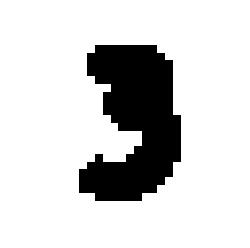

In [0]:

# let's try a stronger attack
with warnings.catch_warnings():
    cw_l2 = CarliniWagnerL2( wrapper, sess=session )
    modified_sample = cw_l2.generate_np( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )

print( 'class prediction for the cw modified test samples:',
       clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )
plt.imshow( modified_sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )
